**Общая информация**

**Срок сдачи:** 21 октября 2020, 08:30 

**Штраф за опоздание:** по 1 баллу за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0220, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_20newsgroups

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from scipy.spatial.distance import cdist
from sklearn.metrics import pairwise_distances, accuracy_score
from sklearn.neighbors import KDTree
from sklearn.model_selection import KFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
sns.set_style(style='darkgrid')

##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

Во время создание модели были замечено интересное наблюдение:

In [11]:
X = np.random.random(1000000).reshape(-1, 1000)

In [12]:
%%timeit
pairwise_distances(X, X)

31 ms ± 1.62 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
%%timeit
cdist(X, X)

508 ms ± 1.93 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Впредь используем только pairwise_distances

In [2]:
class MyKNeighborsClassifier(BaseEstimator):
    
    def __init__(self, n_neighbors, algorithm='brute', metric = 'euclidean'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
        self.metric = metric
        
    def fit(self, X, y):
        if(self.algorithm == 'brute'):
            self.X = X
            self.y = y
        elif(self.algorithm == 'kd_tree'):
            self.tree = KDTree(X, metric=self.metric)
            self.y = y
            
    def get_nearest_neighbors(self, distances):
        indexes = np.argpartition(-distances, -self.n_neighbors, axis=1)[:, -self.n_neighbors:]
        array_top = np.take_along_axis(distances, indexes, axis=1)
        sort_index = np.argsort(array_top, axis=1)
        return np.take_along_axis(indexes, sort_index, axis=1)
    
    def predict(self, X):
        if(self.algorithm == 'brute'):
            distances = pairwise_distances(X, self.X, self.metric)
            indexes = self.get_nearest_neighbors(distances)
        else:
            indexes = self.tree.query(X, self.n_neighbors)[1]
        nearest_neighbors = self.y[indexes]
        return np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=1, arr=nearest_neighbors)
    

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [3]:
iris = datasets.load_iris()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [5]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [6]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [7]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [8]:
%time clf.fit(X_train, y_train)

Wall time: 1 ms


KNeighborsClassifier(algorithm='brute', n_neighbors=2)

In [9]:
%time my_clf.fit(X_train, y_train)

Wall time: 0 ns


In [10]:
%time clf.predict(X_test)

Wall time: 1.69 ms


array([1, 0, 1, 1, 0, 0, 2, 1, 1, 2, 0, 2, 2, 0, 1])

In [11]:
%time my_clf.predict(X_test)

Wall time: 992 µs


array([1, 0, 1, 1, 0, 0, 2, 1, 1, 2, 0, 2, 2, 0, 1], dtype=int64)

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [12]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [13]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [14]:
%time clf.fit(X_train, y_train)

Wall time: 993 µs


KNeighborsClassifier(algorithm='kd_tree', n_neighbors=2)

In [15]:
%time my_clf.fit(X_train, y_train)

Wall time: 509 µs


In [16]:
%time clf.predict(X_test)

Wall time: 12 ms


array([2, 1, 0, 1, 1, 0, 0, 1, 0, 2, 2, 0, 1, 2, 2])

In [17]:
%time my_clf.predict(X_test)

Wall time: 0 ns


array([2, 1, 0, 1, 1, 0, 0, 1, 0, 2, 2, 0, 1, 2, 2], dtype=int64)

In [18]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [19]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [20]:
data = np.asarray(newsgroups['data'])
target = np.asarray(newsgroups['target'])

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [24]:
MAX_FEATURES = 1000

In [25]:
vectorizer = CountVectorizer(max_features=MAX_FEATURES)
X_count = vectorizer.fit_transform(data)

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [26]:
kf = KFold(n_splits=3)

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [27]:
def find_optimal_k(knn_clf, X, target, n_neighbours, kf, algorithm='brute', metric='euclidean'):
    scores = []
    for k in n_neighbours:
        scores_for_neighbour = []
        for train, test in kf.split(X):
            my_clf = knn_clf(k, algorithm=algorithm, metric=metric)
            my_clf.fit(X[train], target[train])
            scores_for_neighbour.append((my_clf.predict(X[test]) == target[test]).sum() / test.size)
        scores.append(np.mean(scores_for_neighbour))
    return scores

def find_optimal_k_shorter(knn_clf, X, target, n_neighbours, cv=5, algorithm='brute', metric='euclidean'):
    scores = []
    for k in n_neighbours:
        my_clf = knn_clf(k, algorithm=algorithm, metric=metric)
        scores.append(cross_val_score(my_clf, X, target, cv=cv, scoring='accuracy').mean())
    return scores

In [28]:
scores_countVect = find_optimal_k_shorter(MyKNeighborsClassifier, X_count, target, np.arange(1, 11), cv=3)

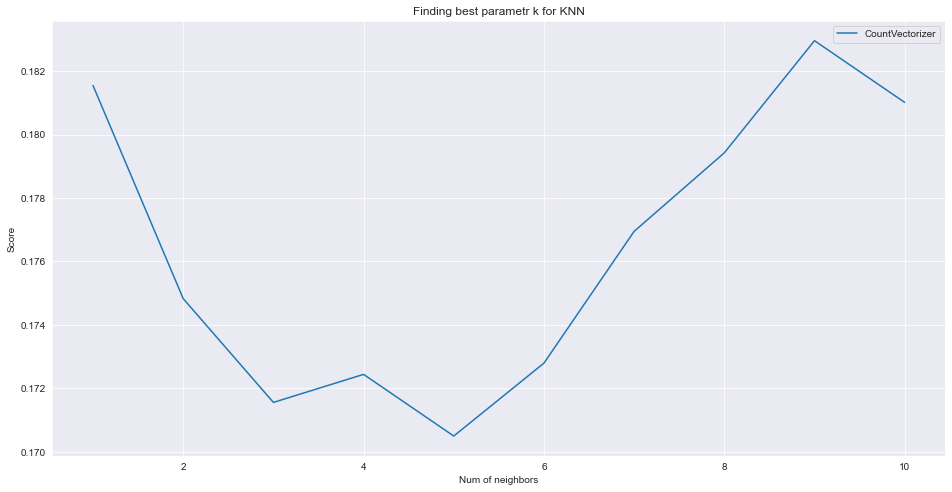

In [29]:
fig, ax = plt.subplots(figsize=(16,8))
ax.set(xlabel='Num of neighbors', ylabel='Score');
ax.set_title('Finding best parametr k for KNN')
sns.lineplot(ax = ax, x=np.arange(1,11), y=scores_countVect, label='CountVectorizer');

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

In [30]:
scores_countVect_cosine = find_optimal_k_shorter(MyKNeighborsClassifier, X_count,
                                                 target, np.arange(1, 11), cv=3, metric='cosine')

In [31]:
tfidf_vectorizer = TfidfVectorizer(max_features=MAX_FEATURES)
X_tfIdf = tfidf_vectorizer.fit_transform(data) # построенная модель не умеет работь с sparse matrix =(

In [32]:
scores_tfIdfVect = find_optimal_k_shorter(MyKNeighborsClassifier, X_tfIdf, target,
                                          np.arange(1, 11), cv=3)

In [33]:
scores_tfIdfVect_cosine = find_optimal_k_shorter(MyKNeighborsClassifier, X_tfIdf, target,
                                          np.arange(1, 11), cv=3, metric='cosine')

In [34]:
models = {'Count vectorizer': scores_countVect,
         'CountVectorizer with cosine metric': scores_countVect_cosine,
         'TfIdf vectorizer': scores_tfIdfVect,
         'TfIdf vectorizer with cosine metric': scores_tfIdfVect_cosine}

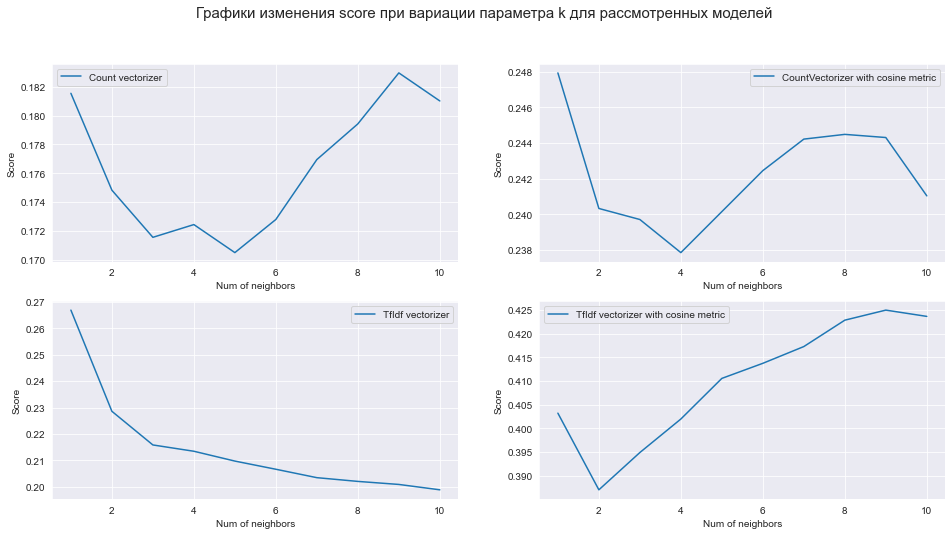

In [35]:
fig, axes = plt.subplots(2, 2, figsize=(16,8))
fig.suptitle("Графики изменения score при вариации параметра k для рассмотренных моделей", fontsize=15)
for ax, label in zip(axes.flatten(), models):
    ax.set(xlabel='Num of neighbors', ylabel='Score');
    sns.lineplot(ax = ax, x=np.arange(1,11), y=models[label], label=label)

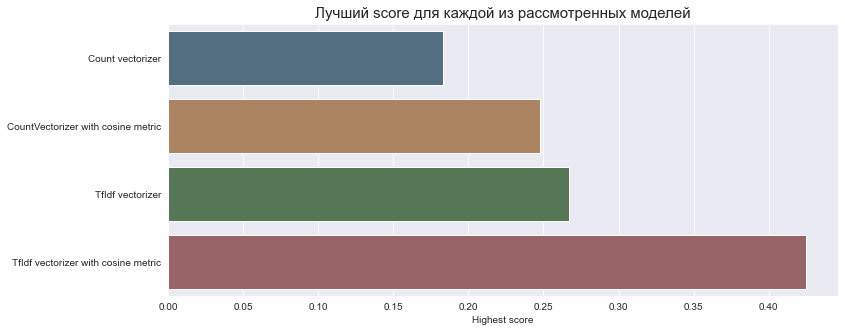

In [36]:
max_scores = []
for name in models:
    max_scores.append(max(models[name]))
fig, ax = plt.subplots(figsize=(12, 5))
ax.set_title('Лучший score для каждой из рассмотренных моделей', fontsize=15)
ax.set(xlabel='Highest score')
sns.barplot(y=list(models.keys()), x=max_scores, saturation=0.3, orient='h');

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [47]:
MAX_FEATURES = 1000

In [75]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])
data_train = np.asarray(newsgroups['data'])
target_train = np.asarray(newsgroups['target'])

vectorizer = TfidfVectorizer(max_features=MAX_FEATURES)
X_train = vectorizer.fit_transform(data_train)

In [76]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])
data_test = np.asarray(newsgroups['data'])
target_test  = np.asarray(newsgroups['target'])
X_test = vectorizer.transform(data_test)

In [77]:
final_clf = MyKNeighborsClassifier(n_neighbors=10, metric='cosine')
final_clf.fit(X_train, target_train)
test_score = accuracy_score(final_clf.predict(X_test), target_test)

In [78]:
np.asarray(scores_tfIdfVect_cosine).mean()

0.4100139208648841

In [79]:
test_score

0.37665958576739245

In [80]:
np.asarray(scores_tfIdfVect_cosine).mean() - test_score

0.03335433509749164

Score отличается но, наверное, не критично. Попробуем исследовать этот вопрос. Узнаем зависит ли это от количества фичей для текста. Так как векторайзер был обучен на train выборке, он будет содержать слова, которых может не быть в test. И наоборот некоторые слова в test выборке утеряны. Еще есть подозрение, что векторайзер могут забивать слова кототрые никак не помогают в классификации, например местоимения, частицы и другие вещи не несущие смысловой нагрузки. Хотя tfidf должно им сильно уменьшить скор, есть предположения что они все равно остались среди этих 1000 фичей. Для проверки моих гипотез ниже я немного поработаю с текстами, а так же увеличу колличество фичей. Посмотрим на сколько сильно будет отличаться score в этом случае. 

In [54]:
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
import re
from functools import reduce

In [55]:
def transform_data(data, target):
    stop_words = set(stopwords.words("english"))
    lemmatizer = WordNetLemmatizer()
    pattern = r"[^\w]"
    data = np.asarray([[lemmatizer.lemmatize(word) for word in 
                        nltk.word_tokenize(re.sub(pattern, " ", text).lower())
                            if not word in stop_words and len(word) > 2] for text in data])
    
    return np.asarray([reduce(lambda x, y: x + " " + y, row) for row in data if len(row) != 0]), \
            np.asarray([target[pair[0]] for pair in enumerate(data) if len(pair[1]) != 0])

In [81]:
MAX_FEATURES = 1000
vectorizer = TfidfVectorizer(max_features=MAX_FEATURES)
data_train, target_train = transform_data(data_train, target_train)
X_train = vectorizer.fit_transform(data_train)

In [82]:
data_test, target_test = transform_data(data_test, target_test)
X_test = vectorizer.transform(data_test)

In [83]:
final_clf = MyKNeighborsClassifier(n_neighbors=10, metric='cosine')
final_clf.fit(X_train, target_train)
test_score = accuracy_score(final_clf.predict(X_test), target_test)

In [84]:
train_scores = find_optimal_k_shorter(MyKNeighborsClassifier, X_train, target_train,
                                          np.arange(1, 11), cv=3, metric='cosine')

In [85]:
np.asarray(train_scores).mean()

0.49009808803138455

In [86]:
test_score

0.4565128064648678

In [87]:
np.asarray(train_scores).mean() - test_score

0.033585281566516745

После обработки разность осталось таже. Наверное tfidf отлично справляется с задачей важных слов, т.е. дает мусорным словам (предлоги, местоимения ... ) мальнекий скор. И они даже не попадают в итоговый вектор фичей. Проверим что будет если менять размер вектора фичей. Возьмем весь словарь.

In [88]:
vectorizer = TfidfVectorizer()
data_train, target_train = transform_data(data_train, target_train)
X_train = vectorizer.fit_transform(data_train)

In [89]:
data_test, target_test = transform_data(data_test, target_test)
X_test = vectorizer.transform(data_test)

In [90]:
final_clf = MyKNeighborsClassifier(n_neighbors=10, metric='cosine')
final_clf.fit(X_train, target_train)
test_score = accuracy_score(final_clf.predict(X_test), target_test)

In [91]:
train_scores = find_optimal_k_shorter(MyKNeighborsClassifier, X_train, target_train,
                                          np.arange(1, 11), cv=3, metric='cosine')

In [92]:
np.asarray(train_scores).mean() 

0.6607257700581551

In [93]:
test_score

0.6188193398164635

In [94]:
np.asarray(train_scores).mean() - test_score

0.041906430241691606

Разность стала больше. Т.е. модель с количеством фичей равной всему словарю сильнее переобучается. Если подумать, это логично. Т.к. изначально мы брали 1000 слов с максимальным скором. Данные слова скорее всего показывали именно основную нагрузку текста для его классификации. Добавив в фичи абсолютно все слова из словаря, мы лучше обучились на трейне на каких-то внутренних патернах, но произвольные тексты такие патерны не повторяют. Как следствие получаем большую разницу скоров на трейне и на тесте. 